In [1]:
import torch
import triton
import triton.language as tl
import my_cuda_ops

In [2]:
# add by cuda
def transpose_cuda(x: torch.Tensor):
    # We need to preallocate the output.
    assert x.is_cuda
    M = x.shape[0]
    N = x.shape[1]
    output = torch.empty((x.shape[1], x.shape[0]), dtype=x.dtype, layout=x.layout, device=x.device)
    # 创建输出张量
    my_cuda_ops.transpose_cuda(x, output, M, N, 2)
    return output

In [3]:
# We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:
torch.manual_seed(0)
x = torch.rand(4096,4096, device='cuda')
output_torch = x.T
output_cuda = transpose_cuda(x)
print(output_torch)
print(output_cuda)
# print(f'The maximum difference between torch and triton is '
#       f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The maximum difference between torch and cuda is '
      f'{torch.max(torch.abs(output_torch - output_cuda))}')

tensor([[0.3990, 0.0660, 0.3499,  ..., 0.7812, 0.5528, 0.5019],
        [0.5167, 0.3372, 0.2987,  ..., 0.7673, 0.0460, 0.4973],
        [0.0249, 0.1096, 0.1116,  ..., 0.1083, 0.1863, 0.2190],
        ...,
        [0.2671, 0.1101, 0.1688,  ..., 0.2943, 0.2498, 0.4623],
        [0.1570, 0.5237, 0.7409,  ..., 0.3955, 0.9550, 0.8097],
        [0.2273, 0.2659, 0.5491,  ..., 0.8534, 0.9173, 0.4038]],
       device='cuda:0')
tensor([[0.3990, 0.0660, 0.3499,  ..., 0.7812, 0.5528, 0.5019],
        [0.5167, 0.3372, 0.2987,  ..., 0.7673, 0.0460, 0.4973],
        [0.0249, 0.1096, 0.1116,  ..., 0.1083, 0.1863, 0.2190],
        ...,
        [0.2671, 0.1101, 0.1688,  ..., 0.2943, 0.2498, 0.4623],
        [0.1570, 0.5237, 0.7409,  ..., 0.3955, 0.9550, 0.8097],
        [0.2273, 0.2659, 0.5491,  ..., 0.8534, 0.9173, 0.4038]],
       device='cuda:0')
The maximum difference between torch and cuda is 0.0


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(3, 15, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['torch', 'cuda'],  # Possible values for `line_arg`.
        line_names=['Torch', 'CUDA'],  # Label name for the lines.
        styles=[('blue', '-'), ('red', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand((size,size), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x.T.contiguous() , quantiles=quantiles)
    if provider == 'cuda':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: transpose_cuda(x), quantiles=quantiles)
    gbps = lambda ms : 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    # gbps = lambda ms : ms
    return gbps(ms), gbps(max_ms), gbps(min_ms)

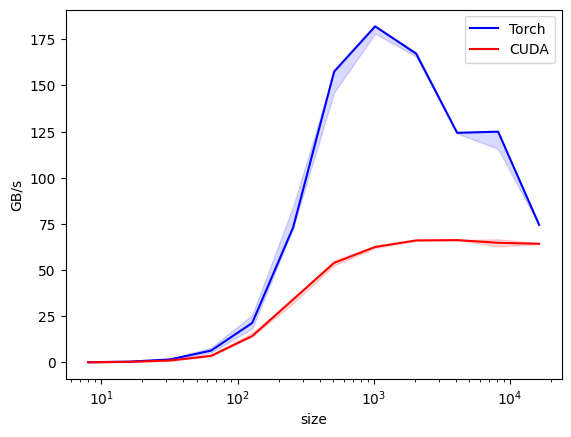

vector-add-performance:
       size       Torch       CUDA
0       8.0    0.100000   0.071429
1      16.0    0.400000   0.285714
2      32.0    1.600000   1.005894
3      64.0    6.400000   3.555555
4     128.0   21.333333  14.222222
5     256.0   73.142856  34.133334
6     512.0  157.538463  53.894739
7    1024.0  182.044442  62.534354
8    2048.0  167.237007  66.064517
9    4096.0  124.356737  66.231432
10   8192.0  124.979260  64.778893
11  16384.0   74.528304  64.258793


In [15]:
benchmark.run(print_data=True, show_plots=True)